In [3]:
import os
import csv
import time
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import gensim
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import euclidean_distances

%matplotlib inline

### Read Data

In [4]:
num_train = 10000
num_train_hold = 2000
num_test = 2000

split_idx = list(range(num_train))
split_idx_train = split_idx[:num_train - num_train_hold]
split_idx_test = split_idx[num_train - num_train_hold:]
random.shuffle(split_idx)

#### Description

In [5]:
def read_descriptions(data_dir, num_doc):
    docs = []
    for i in range(num_doc):
        path = os.path.join(data_dir, "%d.txt" % i)
        with open(path) as f:
            docs.append(f.read())
    return docs

desc_train = read_descriptions("data/descriptions_train", num_doc=num_train)
desc_test = read_descriptions("data/descriptions_test", num_doc=num_test)

print("desc_train:", len(desc_train))
print("desc_test:", len(desc_test))

desc_train: 10000
desc_test: 2000


#### Features

In [6]:
def read_features(features_path):
    vec_map = {}
    with open(features_path) as f:
        for row in csv.reader(f):
            img_id = int(row[0].split("/")[1].split(".")[0])
            vec_map[img_id] = np.array([float(x) for x in row[1:]])
    return np.array([v for k, v in sorted(vec_map.items())])

fc1000_train = read_features("data/features_train/features_resnet1000_train.csv")
fc1000_test = read_features("data/features_test/features_resnet1000_test.csv")
pool5_train = read_features("data/features_train/features_resnet1000intermediate_train.csv")
pool5_test = read_features("data/features_test/features_resnet1000intermediate_test.csv")

print("fc1000_train shape:", fc1000_train.shape)
print("fc1000_test shape:", fc1000_test.shape)
print("pool5_train shape:", pool5_train.shape)
print("pool5_test shape:", pool5_test.shape)

fc1000_train shape: (10000, 1000)
fc1000_test shape: (2000, 1000)
pool5_train shape: (10000, 2048)
pool5_test shape: (2000, 2048)


#### Images

In [7]:
img_dir = 'data/images_train'
def read_image(i):
    return mpimg.imread(os.path.join(img_dir, "%d.jpg" % i))

def read_images(start, end):
    images = []
    for i in range(start, end):
        images.append(read_image(i))
    return images

#### Images with the same argmax feature

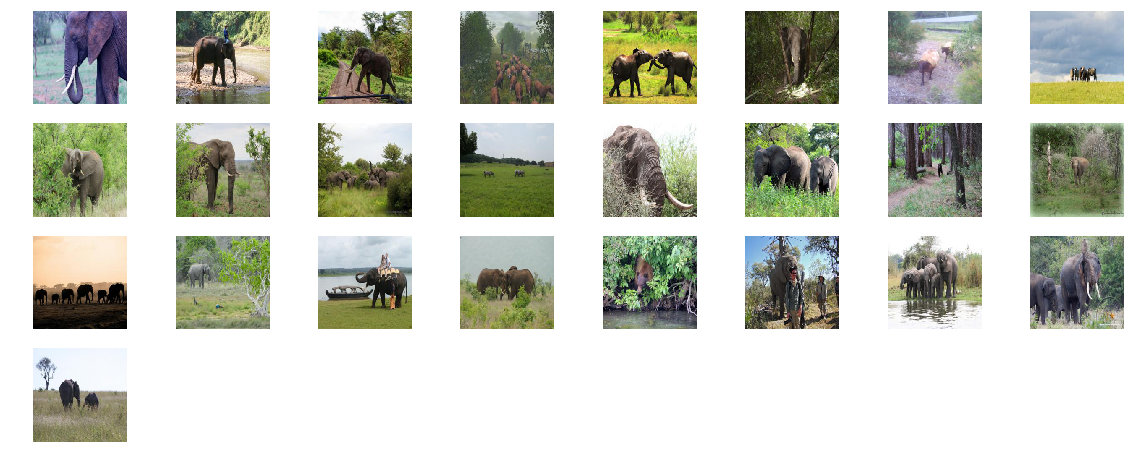

In [8]:
feature_idx = 101

plt.figure(figsize=[20, 10])
def drawImages(images):
    n = len(images)
    n_col = 8
    n_row = n // 6 + 1
    
    for i in range(n):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
result = []
for i in range(num_train):
    if np.argmax(fc1000_train[i]) == feature_idx:
        result.append(read_image(i))

drawImages(result)

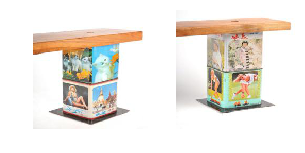

In [9]:
feature_idx = 101

def drawImages(images):
    n = len(images)
    n_col = 8
    n_row = n // 6 + 1
    
    for i in range(n):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    
result = []
for i in range(num_train):
    if np.argmax(pool5_train[i]) == feature_idx:
        result.append(read_image(i))

plt.figure(figsize=[20, 5])
drawImages(result)

#### Parse features to form X matrices and decriptions to Y 

In [10]:
x_dev_train_fc1000 = fc1000_train[split_idx_train]
x_dev_test_fc1000 = fc1000_train[split_idx_test]
x_dev_train_pool5 = pool5_train[split_idx_train]
x_dev_test_pool5 = pool5_train[split_idx_test]

y_dev_train = np.array([desc_train[i] for i in split_idx_train])
y_dev_test = np.array([desc_train[i] for i in split_idx_test])

x_train_fc1000 = np.concatenate([x_dev_train_fc1000, x_dev_test_fc1000])
x_test_fc1000 = fc1000_test
x_train_pool5 = np.concatenate([x_dev_train_pool5, x_dev_test_pool5])
x_test_pool5 = pool5_test

y_test = np.array(desc_test)

print("x_dev_train_fc1000 shape:", x_dev_train_fc1000.shape)
print("x_dev_test_fc1000 shape:", x_dev_test_fc1000.shape)
print("x_dev_train_pool5 shape:", x_dev_train_pool5.shape)
print("x_dev_test_pool5 shape:", x_dev_test_pool5.shape)
print("y_dev_train shape:", y_dev_train.shape)
print("y_dev_test shape:", y_dev_test.shape)
print("x_train_pool5 shape:", x_train_pool5.shape)
print("x_test_pool5 shape:", x_test_pool5.shape)

x_dev_train_fc1000 shape: (8000, 1000)
x_dev_test_fc1000 shape: (2000, 1000)
x_dev_train_pool5 shape: (8000, 2048)
x_dev_test_pool5 shape: (2000, 2048)
y_dev_train shape: (8000,)
y_dev_test shape: (2000,)
x_train_pool5 shape: (10000, 2048)
x_test_pool5 shape: (2000, 2048)


### Text Preprocessing

In [904]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import textblob as tb
from textblob import TextBlob as TB
import inflect
import re
import enchant

stopword_set = set(stopwords.words('english'))
enchant_dict = enchant.Dict("en_US")

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ctc316/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ctc316/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
True


In [1311]:
# Noun, Verb, Adj, (Adv), no Stopwords
def line_process(line):
    res = []
    for w, tag in TB(num_to_word(line)).tags:
#         if (tag[0] == 'N' or tag[0] == 'V' or tag[0] == 'J' or tag[0] == 'R') and w not in stopword_set:
        if w not in stopword_set:
#             res.append(tb.blob.Word(w).singularize())
            res.append(w)
    return res

#and enchant_dict.check(str(bytes(w))  

def num_to_word(line):
    p = inflect.engine()
    return " ".join([p.number_to_words(w) if w.isdigit() else w for w in line.split()])

def rm_punctuation(word_list):
    res = []
    for w in word_list:
        nw = re.sub(r'[^\w\s]', '', w)
        if nw != '':
            res.append(nw)
    return res
            
def stem_words(word_list):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in word_list]

def lemmatize_verbs(word_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, pos='v') for w in word_list]

def rm_duplicate(word_list):
    return list(set(word_list))

#### Process Doc to word list 

In [1312]:
def doc_preprocess(doc):
    res = []
    for line in doc.split("\n"):
        res.extend(line_process(line.lower()))
    
    res = rm_punctuation(res)
    res = stem_words(res)
    res = lemmatize_verbs(res)
#     res = rm_duplicate(res)
    
    return res
    

test_doc = "This is an Apple. Apples are There. I got a banana and 123 bananas." + "\n" + \
           "Running man ran. run run run, he ran!!! Dog Cat 4211 Bird" + "\n" + \
           "I  have a red door. he badly had two blue doors.She has 100 dogs"

print(doc_preprocess(test_doc))

['appl', 'appl', 'get', 'banan', 'on', 'hundr', 'twentythr', 'banana', 'run', 'man', 'run', 'run', 'run', 'run', 'run', 'dog', 'cat', 'four', 'thousand', 'two', 'hundr', 'elev', 'bird', 'red', 'door', 'bad', 'two', 'blu', 'doorssh', 'on', 'hundr', 'dog']


In [1313]:
%%time

y_dev_words_train = np.array([doc_preprocess(doc) for doc in y_dev_train])
y_dev_words_test = np.array([doc_preprocess(doc) for doc in y_dev_test])
y_words_test = np.array([doc_preprocess(doc) for doc in y_test])

print("y_dev_words_train.shape:", y_dev_words_train.shape)
print("y_dev_words_test.shape:", y_dev_words_test.shape)
print("y_words_test.shape:", y_words_test.shape)

y_dev_words_train.shape: (8000,)
y_dev_words_test.shape: (2000,)
y_words_test.shape: (2000,)
CPU times: user 1min 30s, sys: 2.1 s, total: 1min 32s
Wall time: 1min 33s


### Train Model pool5 (X) -> description_wordVec (Y)  (and fc1000 (X) -> description_wordVec (Y))

#### Using the word2vec dictionary by gensim

In [628]:
%%time

word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!
CPU times: user 2min 44s, sys: 8.64 s, total: 2min 53s
Wall time: 6min 34s


#### Parse descriptions to form the Y matrices

In [1368]:
## tf-idf
# def w2v_create_bags(doc_list):
#     #tf
#     word_tf = {}
#     for doc in doc_list:
#         w_cnt = {}
#         for w in doc:
#             if w in w_cnt:
#                 w_cnt[w] += 1
#             else:
#                 w_cnt[w] = 1
        
#         for w in doc:
#             if w not in word_tf:
#                 word_tf[w] = w_cnt[w] / len(doc)
#             else: 
#                 word_tf[w] += w_cnt[w] / len(doc) 
                
#     #idf
#     word_idf = {}
#     for doc in doc_list:
#         for w in list(set(doc)):
#             if w in word_idf:
#                 word_idf[w] += 1
#             else:
#                 word_idf[w] = 1
    
#     scores = []    
#     bags = []
#     for w, v in word_tf.items():
#         scores.append(v * (len(doc_list) / word_idf[w]))
#         if v * (len(doc_list) / word_idf[w]) > 300:
#             bags.append(w)
    
#     bags_idx_map = {}
#     for i, word in enumerate(bags):
#         bags_idx_map[word] = i
        
#     return bags_idx_map


## simple threshold
# def w2v_create_bags(words_list):
#     word_cnts = {}
#     for words in words_list:
#         for w in words:
#             if w in word_cnts:
#                 word_cnts[w] += 1
#             else:
#                 word_cnts[w] = 1
    
#     bags = []
#     for k, v in word_cnts.items():
#         if v >= 3:
#             bags.append(k)
    
#     idx_map = {}
#     for i, word in enumerate(bags):
#         idx_map[word] = i
        
#     return idx_map


def w2v_create_bags(doc_list):
    from queue import PriorityQueue
    num_of_words_selected = 5
    bags = set()
    #idf
    word_idf = {}
    for doc in doc_list:
        for w in list(set(doc)):
            if w in word_idf:
                word_idf[w] += 1
            else:
                word_idf[w] = 1  
    #tf
    for doc in doc_list:
        w_cnt = {}
        for w in doc:
            if w in w_cnt:
                w_cnt[w] += 1
            else:
                w_cnt[w] = 1
                
        pq = PriorityQueue()
        for w, cnt in w_cnt.items():
            pq.put((cnt / word_idf[w], w))
            if pq.qsize() > num_of_words_selected:
                pq.get()
        for _ in range(pq.qsize()):    
            bags.add(pq.get()[1])
            
    return bags

In [1369]:
def doc_to_vec(words, word2vec):
    word_vecs = [word2vec.get_vector(w) for w in words if w in word2vec.vocab]
    return np.stack(word_vecs).mean(0)

w2v_bags = w2v_create_bags(y_dev_words_train)
print(len(w2v_bags))
# print(list(w2v_bags))

def filter_words(doc_list):
    res = []
    for doc in doc_list:
        res.append([w for w in doc if w in w2v_bags])
    return res
        
y_w2v_dev_train = np.array([doc_to_vec(words, word2vec) for words in filter_words(y_dev_words_train)])
y_w2v_dev_test = np.array([doc_to_vec(words, word2vec) for words in filter_words(y_dev_words_test)])

print("y_w2v_dev_train shape:", y_w2v_dev_train.shape)
print("y_w2v_dev_test shape:", y_w2v_dev_test.shape)

5299
y_w2v_dev_train shape: (8000, 300)
y_w2v_dev_test shape: (2000, 300)



#### Test performance on development set

In [1380]:
%%time

def train_model(x, y):
#     parameters = {"alpha": [500]}
    reg = Ridge(alpha=105) # GridSearchCV(Ridge(), parameters, cv=5)
    reg.fit(x, y)
    return reg

# reg_w2v_dev_fc1000 = train_model(x_dev_train_fc1000, y_w2v_dev_train)
reg_w2v_dev_pool5 = train_model(x_dev_train_pool5, y_w2v_dev_train)

# print("Summary of best model:")
# print(reg_w2v_dev_fc1000.best_estimator_)
# print(reg_w2v_dev_pool5.best_estimator_)

CPU times: user 3.73 s, sys: 276 ms, total: 4.01 s
Wall time: 1.12 s


In [1381]:
%%time

weights = [0, 1]
# y_w2v_dev_pred_fc1000 = reg_w2v_dev_fc1000.predict(x_dev_test_fc1000)
y_w2v_dev_pred_pool5 = reg_w2v_dev_pool5.predict(x_dev_test_pool5)

w2v_dev_distances = 0
# w2v_dev_distances += weights[0] * euclidean_distances(y_w2v_dev_test, y_w2v_dev_pred_fc1000)
w2v_dev_distances += weights[1] * euclidean_distances(y_w2v_dev_test, y_w2v_dev_pred_pool5)

dev_scores = []
dev_pos_list = []
for i in range(num_test):
    pred_dist_idx = list(np.argsort(w2v_dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)
        
print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

Development MAP@20: 0.30427335328929755
Mean index of true image 28.679
Median index of true image 7.0
CPU times: user 1.22 s, sys: 109 ms, total: 1.33 s
Wall time: 695 ms


#### Predict on test data

In [1382]:
%%time

y_w2v_train = np.concatenate([y_w2v_dev_train, y_w2v_dev_test])
y_w2v_test = np.array([doc_to_vec(words, word2vec) for words in y_words_test])

# reg_w2v_fc1000 = train_model(x_train_fc1000, y_w2v_train)
reg_w2v_pool5 = train_model(x_train_pool5, y_w2v_train)


print("y_w2v_train:",y_w2v_train.shape)
print("y_w2v_test:",y_w2v_test.shape)
# print(reg_fc1000.best_estimator_)
# print(reg_w2v_pool5.best_estimator_)

y_w2v_train: (10000, 300)
y_w2v_test: (2000, 300)
CPU times: user 4.81 s, sys: 351 ms, total: 5.16 s
Wall time: 1.77 s


#### Submission

In [1383]:
# y_w2v_pred_fc1000 = reg_w2v_fc1000.predict(x_test_fc1000)
y_w2v_pred_pool5 = reg_w2v_pool5.predict(x_test_pool5)

w2v_distances = 0
# distances += weights[0] * euclidean_distances(y_w2v_test, y_w2v_pred_fc1000)
w2v_distances += weights[1] * euclidean_distances(y_w2v_test, y_w2v_pred_pool5)

pred_rows = []
for i in range(num_test):
    top_20 = list(np.argsort(w2v_distances[i]))[:20]
    row = ["%d.jpg" % i for i in top_20]
    pred_rows.append(" ".join(row))

with open("submission/submission_word2Vec_" + time.strftime('%m%d_%H%M%S') + ".csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")

Output written!


### Train Model pool5 (X) -> description_BOW (Y)  (and fc1000 (X) -> description_BOW (Y))

#### Bag of Words

In [1385]:
## tf-idf
# def create_bags(doc_list):
#     #tf
#     word_tf = {}
#     for doc in doc_list:
#         w_cnt = {}
#         for w in doc:
#             if w in w_cnt:
#                 w_cnt[w] += 1
#             else:
#                 w_cnt[w] = 1
        
#         for w in doc:
#             if w not in word_tf:
#                 word_tf[w] = w_cnt[w] / len(doc)
#             else: 
#                 word_tf[w] += w_cnt[w] / len(doc) 
                
#     #idf
#     word_idf = {}
#     for doc in doc_list:
#         for w in list(set(doc)):
#             if w in word_idf:
#                 word_idf[w] += 1
#             else:
#                 word_idf[w] = 1
    
#     scores = []    
#     bags = []
#     for w, v in word_tf.items():
#         scores.append(v * (len(doc_list) / word_idf[w]))
#         if v * (len(doc_list) / word_idf[w]) > 190:
#             bags.append(w)
    
#     bags_idx_map = {}
#     for i, word in enumerate(bags):
#         bags_idx_map[word] = i
        
#     return bags_idx_map


## simple threshold
# def create_bags(words_list):
#     word_cnts = {}
#     for words in words_list:
#         for w in words:
#             if w in word_cnts:
#                 word_cnts[w] += 1
#             else:
#                 word_cnts[w] = 1
    
#     bags = []
#     for k, v in word_cnts.items():
#         if v >= 3:
#             bags.append(k)
    
#     idx_map = {}
#     for i, word in enumerate(bags):
#         idx_map[word] = i
        
#     return idx_map

def create_bags(doc_list):
    from queue import PriorityQueue
    num_of_words_selected = 5
    bags = set()
    #idf
    word_idf = {}
    for doc in doc_list:
        for w in list(set(doc)):
            if w in word_idf:
                word_idf[w] += 1
            else:
                word_idf[w] = 1  
    #tf
    for doc in doc_list:
        w_cnt = {}
        for w in doc:
            if w in w_cnt:
                w_cnt[w] += 1
            else:
                w_cnt[w] = 1
                
        pq = PriorityQueue()
        for w, cnt in w_cnt.items():
            pq.put((cnt / word_idf[w], w))
            if pq.qsize() > num_of_words_selected:
                pq.get()
        for _ in range(pq.qsize()):    
            bags.add(pq.get()[1])
            
    idx_map = {}
    for i, word in enumerate(bags):
        idx_map[word] = i
            
    return idx_map


def bag_of_words(words, bags_idx_map):
    res = [0 for _ in range(len(bags_idx_map))]
    for w in words:
        if w in bags_idx_map:
            res[bags_idx_map[w]] = 1
    return res

#### Test performance on development set

In [1386]:
dev_bags_idx_map = create_bags(y_dev_words_train)

y_bow_dev_train = np.array([bag_of_words(words, dev_bags_idx_map) for words in y_dev_words_train])
y_bow_dev_test = np.array([bag_of_words(words, dev_bags_idx_map) for words in y_dev_words_test])

print("y_bow_dev_train shape:", y_bow_dev_train.shape)
print("y_bow_dev_test shape:", y_bow_dev_test.shape)

y_bow_dev_train shape: (8000, 5299)
y_bow_dev_test shape: (2000, 5299)


In [1395]:
%%time

def train_model(x, y):
#     parameters = {"alpha": [200]}
    reg = Ridge(alpha=235) # GridSearchCV(Ridge(), parameters, cv=5)
#     reg = PLSRegression(n_components=800, max_iter=1000)
    reg.fit(x, y)
    return reg

# reg_bow_dev_fc1000 = train_model(x_dev_train_fc1000, y_bow_dev_train)
reg_bow_dev_pool5 = train_model(x_dev_train_pool5, y_bow_dev_train)

# print("Summary of best model:")
# print(reg_bow_dev_fc1000.best_estimator_)
# print(reg_bow_dev_pool5.best_estimator_)

CPU times: user 19.5 s, sys: 727 ms, total: 20.2 s
Wall time: 5.09 s


In [1396]:
%%time

weights = [0, 1]
# y_bow_dev_pred_fc1000 = reg_bow_dev_fc1000.predict(x_dev_test_fc1000)
y_bow_dev_pred_pool5 = reg_bow_dev_pool5.predict(x_dev_test_pool5)

bow_dev_distances = 0
# bow_dev_distances += weights[0] * euclidean_distances(y_bow_dev_test, y_bow_dev_pred_fc1000)
bow_dev_distances += weights[1] * euclidean_distances(y_bow_dev_test, y_bow_dev_pred_pool5)

dev_scores = []
dev_pos_list = []
for i in range(num_test):
    pred_dist_idx = list(np.argsort(bow_dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)
        
print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

Development MAP@20: 0.401439599422765
Mean index of true image 16.171
Median index of true image 3.0
CPU times: user 6.03 s, sys: 249 ms, total: 6.28 s
Wall time: 1.88 s


#### Predict on test data

In [1397]:
%%time

y_words_train = np.concatenate([y_dev_words_train, y_dev_words_test])
bags_idx_map = create_bags(y_words_train)

y_bow_train = np.array([bag_of_words(words, bags_idx_map) for words in y_words_train])
y_bow_test = np.array([bag_of_words(words, bags_idx_map) for words in y_words_test])

# reg_bow_fc1000 = train_model(x_train_fc1000, y_bow_train)
reg_bow_pool5 = train_model(x_train_pool5, y_bow_train)

print("y_bow_train shape:", y_bow_train.shape)
print("y_bow_test shape:", y_bow_test.shape)
# print(reg_bow_fc1000.best_estimator_)
# print(reg_bow_pool5.best_estimator_)

y_bow_train shape: (10000, 5786)
y_bow_test shape: (2000, 5786)
CPU times: user 34.8 s, sys: 1.28 s, total: 36.1 s
Wall time: 18.3 s


In [1398]:
# y_bow_pred_fc1000 = reg_bow_fc1000.predict(x_test_fc1000)
y_bow_pred_pool5 = reg_bow_pool5.predict(x_test_pool5)

bow_distances = 0
# bow_distances += weights[0] * euclidean_distances(y_bow_test, y_bow_pred_fc1000)
bow_distances += weights[1] * euclidean_distances(y_bow_test, y_bow_pred_pool5)

pred_rows = []
for i in range(num_test):
    top_20 = list(np.argsort(bow_distances[i]))[:20]
    row = ["%d.jpg" % i for i in top_20]
    pred_rows.append(" ".join(row))

with open("submission/submission_BOW_" + time.strftime('%m%d_%H%M%S') + ".csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")

Output written!


### Merge results from 2 models

In [1399]:
from sklearn.preprocessing import StandardScaler

def standardize(data):
    scaler = StandardScaler()
    scaler.fit(data)
#     print("mean:", scaler.mean_[:5])
#     print("var_:", scaler.var_[:5])
    return scaler.transform(data)

#### Development: Standardize output distances from 2 models

In [1400]:
std_w2v_dev_distances = standardize(w2v_dev_distances.T).T
std_bow_dev_distances = standardize(bow_dev_distances.T).T

print("before:", w2v_dev_distances[0][:5])
print("after:", std_w2v_dev_distances[0][:5])
print("before:", bow_dev_distances[0][:5])
print("after:", std_bow_dev_distances[0][:5])

print("std_w2v_dev_distances shape:", std_w2v_dev_distances.shape)
print("std_w2v_dev_distances shape:", std_w2v_dev_distances.shape)

before: [0.78316075 0.97848283 1.08531744 1.39357945 1.41681587]
after: [-3.44756383 -2.04654023 -1.28022744  0.93090163  1.0975739 ]
before: [3.36781862 3.71214592 3.80476317 4.11708439 4.20212444]
after: [-3.53052918 -1.84079104 -1.38628482  0.14638795  0.5637101 ]
std_w2v_dev_distances shape: (2000, 2000)
std_w2v_dev_distances shape: (2000, 2000)


#### Development: prediction

In [1417]:
weights = [1, 3.85]

merge_dev_distances = weights[0] * std_w2v_dev_distances + weights[1] * std_bow_dev_distances

print("w2v:", std_w2v_dev_distances[0][:3])
print("bow:", std_bow_dev_distances[0][:3])
print("merged:", merge_dev_distances[0][:3])
print("merge_dev_distance shape:", merge_dev_distances.shape)

dev_scores = []
dev_pos_list = []
dev_pred_rows = []
for i in range(num_test):
    pred_dist_idx = list(np.argsort(merge_dev_distances[i]))
    dev_pos = pred_dist_idx.index(i)
    dev_pos_list.append(dev_pos)
    dev_pred_rows.append(pred_dist_idx[:20])
    if dev_pos < 20:
        dev_scores.append(1 / (dev_pos + 1))
    else:
        dev_scores.append(0.0)
        
print("Development MAP@20:", np.mean(dev_scores))
print("Mean index of true image", np.mean(dev_pos_list))
print("Median index of true image", np.median(dev_pos_list))

w2v: [-3.44756383 -2.04654023 -1.28022744]
bow: [-3.53052918 -1.84079104 -1.38628482]
merged: [-17.04010117  -9.13358575  -6.61742401]
merge_dev_distance shape: (2000, 2000)
Development MAP@20: 0.41451558221620144
Mean index of true image 14.32
Median index of true image 3.0


#### Submission: Standardize output distances from 2 models

In [1418]:
std_w2v_distances = w2v_distances #standardize(w2v_distances)
std_bow_distances = bow_distances #standardize(bow_distances)

print("before:", w2v_distances[0][:5])
print("after:", std_w2v_distances[0][:5])
print("before:", bow_distances[0][:5])
print("after:", std_bow_distances[0][:5])

print("std_w2v_dev_distances shape:", std_w2v_distances.shape)
print("std_w2v_dev_distances shape:", std_w2v_distances.shape)

before: [0.80434008 0.86197172 0.71694354 0.62455137 1.14149813]
after: [0.80434008 0.86197172 0.71694354 0.62455137 1.14149813]
before: [4.60306552 4.60660581 4.55296617 4.29430239 4.75696615]
after: [4.60306552 4.60660581 4.55296617 4.29430239 4.75696615]
std_w2v_dev_distances shape: (2000, 2000)
std_w2v_dev_distances shape: (2000, 2000)


In [1419]:
merge_distances = weights[0] * std_w2v_distances + weights[1] * std_bow_distances

pred_rows = []
for i in range(num_test):
    top_20 = list(np.argsort(merge_distances[i]))[:20]
    row = ["%d.jpg" % i for i in top_20]
    pred_rows.append(" ".join(row))

with open("submission/submission_Merge_" + time.strftime('%m%d_%H%M%S') + ".csv", "w") as f:
    f.write("Descritpion_ID,Top_20_Image_IDs\n")
    for i, row in enumerate(pred_rows):
        f.write("%d.txt,%s\n" % (i, row))

print("Output written!")

Output written!


### Visualize Result

#### Development result

a woman and her baby and a stuffed bear
A baby sitting on mom's lap is looking at a teddy bear.
a small child is sitting with a stuffed animal
A woman holding a child and a stuffed animal.
A woman holding a baby girl and a large stuffed teddy bear.

Ans: Image 8011


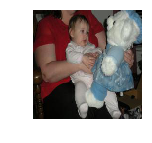

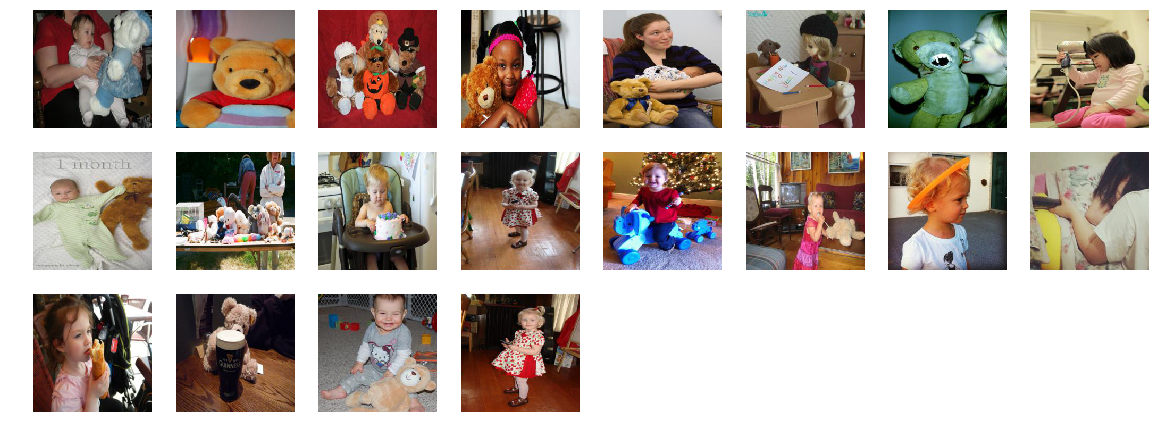

In [93]:
dev_test_idx = 11

print(desc_train[split_idx_test[dev_test_idx]])

plt.figure(figsize=[2, 2])
plt.imshow(read_image(split_idx_test[dev_test_idx]))
plt.axis("off")
print("Ans: Image", split_idx_test[dev_test_idx])


result = []
for i in dev_pred_rows[dev_test_idx]:
    result.append(read_image(split_idx_test[i]))

plt.figure(figsize=[20, 10])
drawImages(result)

#### Final result

A brown teddy bear standing next to bottles of honey.
A very cute teddy bear sitting with a bunch of honey.
THERE IS A BEAR THAT IS NEXT TO BEARS IN HONEY JARS
A small stuffed bear next to several honey containers that look like bears.
Display of honey in various types of containers with a bear sitting in front.



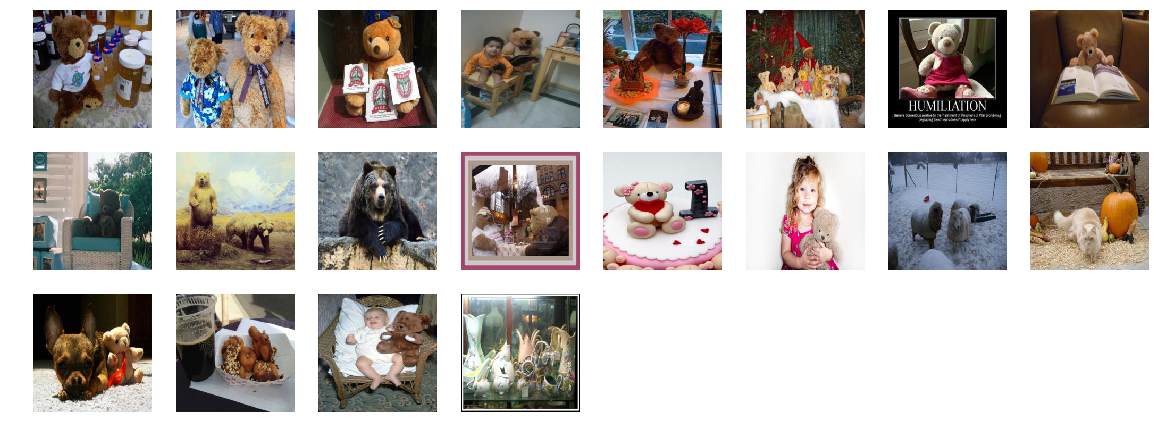

In [69]:
desc_idx = 99

def read_test_image(i):
    return mpimg.imread(os.path.join('data/images_test', "%d.jpg" % i))

print(desc_test[split_idx_test[desc_idx]])

result = []
for img_name in pred_rows[desc_idx].split():
    result.append(read_test_image(int(img_name.split(".")[0])))

plt.figure(figsize=[20, 10])
drawImages(result)